# Brain Tumor Classification using PCA and CNN

Data obtained from https://figshare.com/articles/brain_tumor_dataset/1512427

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn import metrics
from sklearn.neural_network import MLPClassifier

import h5py 
from glob import glob

Preview Data

In [3]:
data_dir = 'data/brainTumorDataPublic/'
filename = data_dir + '2.mat'

data = h5py.File(filename, 'r')
slice = data['cjdata']

for field in slice.keys():
    print('*'*20)
    print(field, slice[field].value)

********************
PID [[49]
 [48]
 [48]
 [51]
 [54]
 [48]]
********************
image [[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
********************
label [[ 1.]]
********************
tumorBorder [[ 319.33101045  153.42160279  302.38327526  161.44947735  292.57142857
   160.55749129  283.65156794  165.90940767  272.94773519  176.61324042
   268.48780488  184.64111498  269.37979094  195.34494774  270.271777
   200.69686411  264.02787456  209.61672474  264.91986063  215.86062718
   272.94773519  222.99651568  267.59581882  231.91637631  272.05574913
   242.62020906  279.19163763  244.40418118  288.11149826  255.10801394
   296.13937282  256.89198606  304.16724739  256.89198606  312.19512195
   253.32404181  321.11498258  248.8641115   325.57491289  248.8641115
   334.49477352  248.8641115   340.73867596  249.75609756  354.1184669
   245.29616725  363.93031359  231.91637631  368.3902439   220.32055749

Sample Image

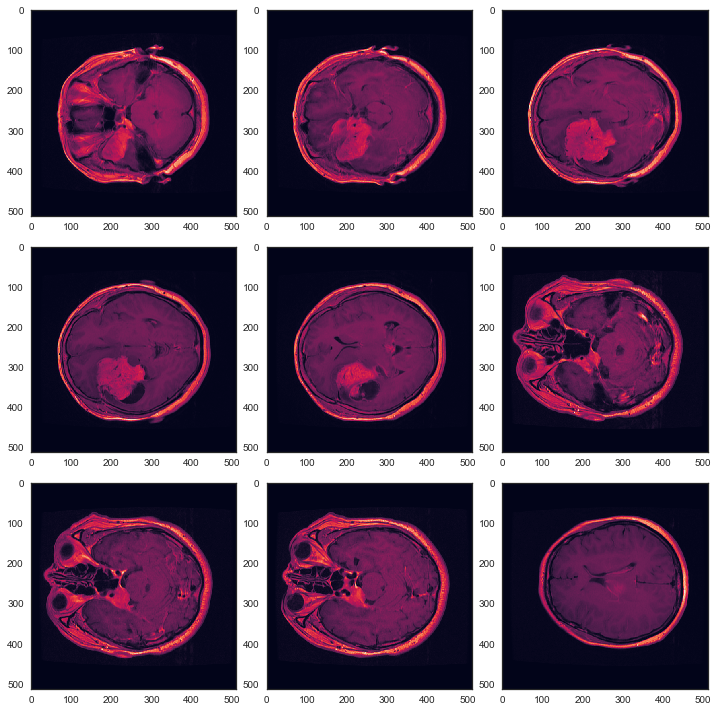

In [4]:
plt.figure(figsize=(10,10))
for num in range(1,10):
    
    plt.subplot(3,3,num)

    filename = data_dir + str(num) + ".mat"
    data = h5py.File(filename, 'r')
    slice = data['cjdata']
    plt.imshow(slice['image'],interpolation='none')

plt.tight_layout()

Preliminary Data Analysis

In [5]:
key = 'cjdata'
total_data_size = 3064
num_group = {'meningioma': 708, 'glioma': 1426, 'pituitary': 930}

num_patients = 233
fields = ['label', 'PID', 'image', 'tumorBorder', 'tumorMask']

image_dim = len(slice['image']) # 512

Data prep using Keras

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

In [8]:
Y = [] # labels
X = [] # images

for fname in glob(data_dir+"*.mat"):
    data = h5py.File(fname, 'r')
    slice = data['cjdata']
    Y.append(int(slice['label'][0][0])) 
    pixels = np.concatenate([np.array(row) for row in slice['image']])
    X.append(pixels)

# start index from 0 instead of 1
for i in range(len(Y)):
    Y[i] -= 1
    

In [12]:
random_seed = 2
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [13]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train, num_classes = 3)

In [14]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(2451,) (613,)
(2451, 3) (613,)


CNN

In [20]:
classifier = Sequential()

classifier.add(Conv2D(32,(5,5), input_shape = (28,28,1), activation = 'relu'))
classifier.add(MaxPool2D(pool_size = (2,2)))

classifier.add(Conv2D(32,(5,5), activation = 'relu'))
classifier.add(Conv2D(32,(5,5), activation = 'relu'))
classifier.add(MaxPool2D(pool_size = (2,2)))

classifier.add(Flatten())

classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dense(units=10, activation='softmax'))

In [21]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

ValueError: setting an array element with a sequence.